In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import glob
from dask.diagnostics import ProgressBar
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})

In [2]:
rootdir = '../data/processed/regridded'
variable = '*'
config = 'GFDL_CM2.1'
averaging = 'mean'
gridname = '*'

In [3]:
grido = xr.open_dataset(rootdir+'/grid_1x1_depth.nc').rename({'x':'xo','y':'yo','z':'zo'})
grida = xr.open_dataset(rootdir+'/grid_3x2_pressure.nc').rename({'x':'xa','y':'ya','z':'za'})

In [4]:
def preprocess(ds):
    filename_elements = ds.encoding["source"].split('/')[-1].split('.')
    # accounting for some errors in file naming
    if filename_elements[0] in ['CESM1','GFDL_CM2','HadCM3BL_M2','HadCM3B_M2']:
        config='.'.join(filename_elements[0:1])
        variable = filename_elements[2]
    else:
        config = filename_elements[0]
        variable = filename_elements[1]
    
    if variable in ['tos','thetao']:
        ds = ds.rename({'x':'xo','y':'yo'})
        if 'z' in ds.coords:
            ds = ds.rename({'z':'zo'})
    elif variable in ['tas','ta']:
        ds = ds.rename({'x':'xa','y':'ya'})
        if 'z' in ds.coords:
            ds = ds.rename({'z':'za'})
    if (config=='NorESM1_F') & (variable in ['tos','thetao']):
        return ds
    else:
        return ds.mean('time')

In [5]:
configs = ['COSMOS-landveg_r2413','CESM1.2_CAM5','GFDL_CM2.1',
                'INM-CM4-8','MIROC4m','NorESM1_F','HadCM3BL_M2.1aN','HadCM3B_M2.1aN']

In [6]:
dd = {}
for config in configs:
    filename = '.'.join([config,variable,averaging,gridname,'nc'])
    path = '/'.join([rootdir,filename])
    dd[config] = xr.open_mfdataset(path,preprocess=preprocess)

In [9]:
variable1 = 'tos'
variable2 = 'thetao'

dv1 = xr.Dataset()
dv2 = xr.Dataset()
for config in configs:
    if config=='COSMOS-landveg_r2413': # issue with COSMOS levels
        continue
    ds = dd[config]
    variable1mean = ds[variable1].weighted(grido['area'].fillna(0)).mean(['xo','yo'],skipna=True)
    variable2mean = ds[variable2].sel({'zo':slice(2000,None)}).weighted(grido['volume'].fillna(0)).mean(['xo','yo','zo'],skipna=True)
    dv1[config] = variable1mean#-variable1mean.sel(experiment='piControl')
    dv2[config] = variable2mean#-variable2mean.sel(experiment='piControl')

In [10]:
with ProgressBar():
    dv1 = dv1.compute()
    dv2 = dv2.compute()

[########################################] | 100% Completed | 108.35 ms
[########################################] | 100% Completed | 94.04 s


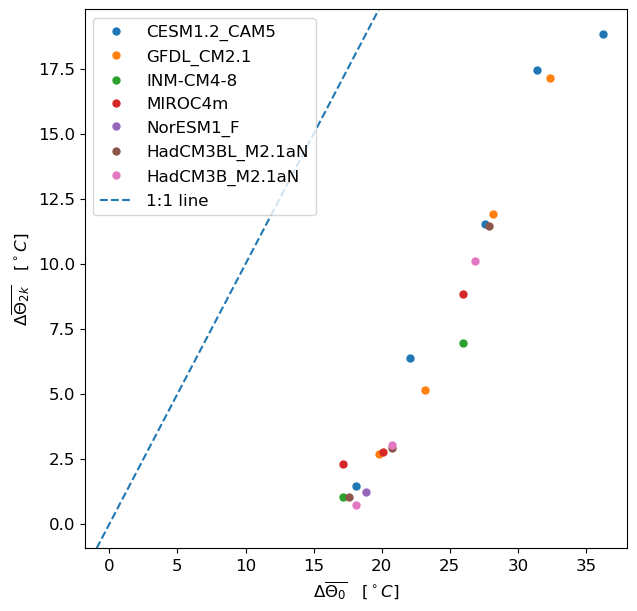

In [14]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(7,7))
for config in dv1.data_vars:
    ax.plot(dv1[config],dv2[config],'.',label=config,markersize=10)
ax.axline((0, 0), (1, 1), linestyle='--',label='1:1 line')
ax.set_ylabel(r'$\Delta\overline{\Theta_{2k}}\quad [^\circ C]$')
ax.set_xlabel(r'$\Delta\overline{\Theta_{0}}\quad [^\circ C]$')
ax.legend()

In [15]:
variable1 = 'tas'
variable2 = 'thetao'

dv1 = xr.Dataset()
dv2 = xr.Dataset()
for config in configs:
    if config=='COSMOS-landveg_r2413': # issue with COSMOS levels
        continue
    ds = dd[config]
    variable1mean = ds[variable1].weighted(grida['area'].fillna(0)).mean(['xa','ya'],skipna=True)
    variable2mean = ds[variable2].sel({'zo':slice(2000,None)}).weighted(grido['volume'].fillna(0)).mean(['xo','yo','zo'],skipna=True)
    dv1[config] = variable1mean#-variable1mean.sel(experiment='piControl')
    dv2[config] = variable2mean#-variable2mean.sel(experiment='piControl')

In [16]:
with ProgressBar():
    dv1 = dv1.compute()
    dv2 = dv2.compute()

[########################################] | 100% Completed | 108.09 ms
[########################################] | 100% Completed | 92.49 s


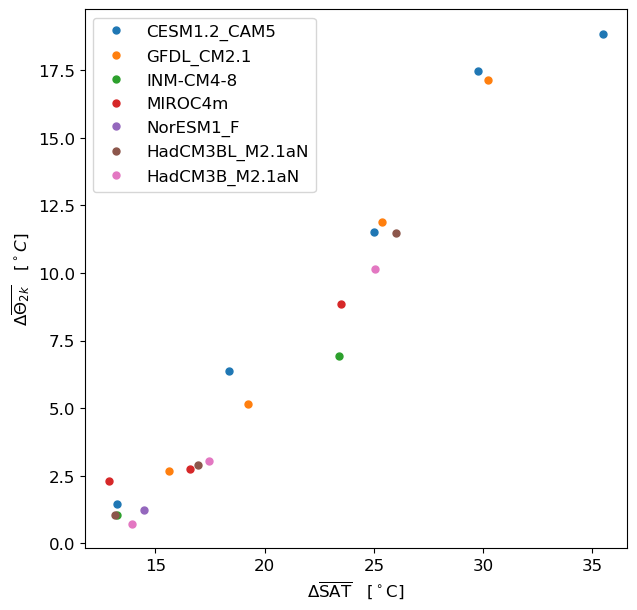

In [25]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(7,7))
for config in dv1.data_vars:
    ax.plot(dv1[config]-273.15,dv2[config],'.',label=config,markersize=10)
# ax.axline((0, 0), (1, 1), linestyle='--',label='1:1 line')
ax.set_ylabel(r'$\Delta\overline{\Theta_{2k}}\quad [^\circ C]$')
ax.set_xlabel(r'$\Delta\overline{\rm SAT}\quad [^\circ C]$')
ax.legend()

In [258]:
dsz = ds_thetao.mean('time').weighted(ds['area'].fillna(0)).mean(['y','x'])

/var/folders/89/8wbtnb1d5y30tjpcqtlr5f840000gq/T/ipykernel_59391/512249191.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ((dsz-dsz['piControl'])).drop(['area','dz','piControl']).to_array('experiment').plot(hue='experiment')


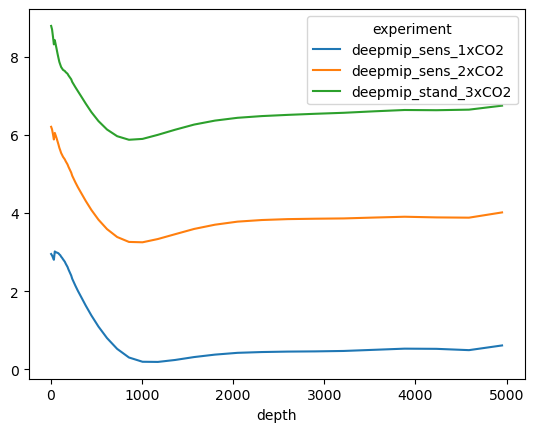

In [260]:
((dsz-dsz['piControl'])).drop(['area','dz','piControl']).to_array('experiment').plot(hue='experiment')

/var/folders/89/8wbtnb1d5y30tjpcqtlr5f840000gq/T/ipykernel_59391/3856996595.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ((dsz-dsz['piControl'])-(dsz-dsz['piControl']).weighted(ds['dz'].fillna(0)).mean('depth')).drop(['area','dz','piControl']).to_array('experiment').plot(hue='experiment')


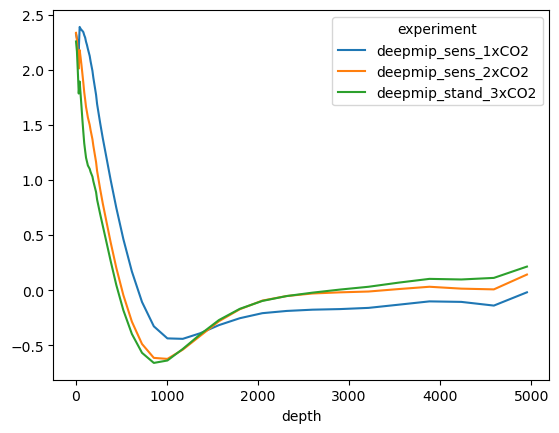

In [262]:
((dsz-dsz['piControl'])-(dsz-dsz['piControl']).weighted(ds['dz'].fillna(0)).mean('depth')).drop(['area','dz','piControl']).to_array('experiment').plot(hue='experiment')